In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from forecasting_utils import *

In [2]:
holidays_events_dir = 'data/holidays_events.csv'
oil_dir = 'data/oil.csv'
stores_dir = 'data/stores.csv'
test_dir = 'data/test.csv'
train_dir = 'data/train.csv'
transactions_dir = 'data/transactions.csv'

holidays_events = pd.read_csv(holidays_events_dir, parse_dates=['date'], infer_datetime_format=True)
stores = pd.read_csv(stores_dir)
train = pd.read_csv(train_dir, parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv(transactions_dir, parse_dates=['date'], infer_datetime_format=True)
oil = pd.read_csv(oil_dir, parse_dates=['date'], infer_datetime_format=True)
test = pd.read_csv(test_dir, parse_dates=['date'], infer_datetime_format=True)

store_sales = train.copy()
store_sales['date'] = train.date.dt.to_period('D')
store_sales = store_sales.set_index(['date', 'store_nbr', 'family']).sort_index()

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_index()

train.onpromotion.astype("float16")
train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")
test.onpromotion.astype("float16")


date        store_nbr  family                    
2017-08-16  1          AUTOMOTIVE                     0.0
                       BABY CARE                      0.0
                       BEAUTY                         2.0
                       BEVERAGES                     20.0
                       BOOKS                          0.0
                                                     ... 
2017-08-31  54         POULTRY                        0.0
                       PREPARED FOODS                 0.0
                       PRODUCE                        1.0
                       SCHOOL AND OFFICE SUPPLIES     0.0
                       SEAFOOD                        0.0
Name: onpromotion, Length: 28512, dtype: float16

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
mean_daily_sales = train.groupby('date').mean()['sales']
mean_weekly_sales = mean_daily_sales.rolling(window=7, center=True, min_periods=3).mean()
mean_monthly_sales = mean_daily_sales.rolling(window=30, center=True, min_periods=15).mean()
mean_yearly_sales = mean_daily_sales.rolling(window=365, center=True, min_periods=183).mean()

C:\Users\HM191112\AppData\Local\Temp\ipykernel_4312\3468515048.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_daily_sales = train.groupby('date').mean()['sales']


<Axes: xlabel='date'>

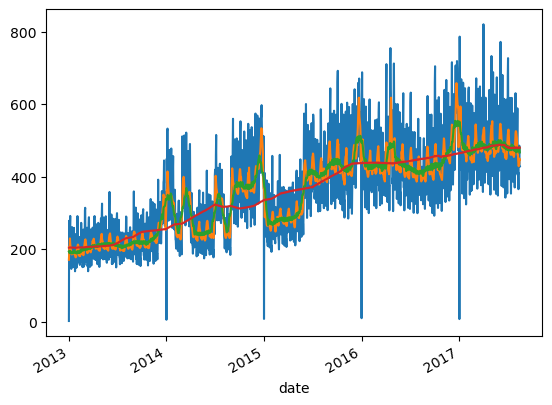

In [5]:
mean_daily_sales.plot()
mean_weekly_sales.plot()
mean_monthly_sales.plot()
mean_yearly_sales.plot()


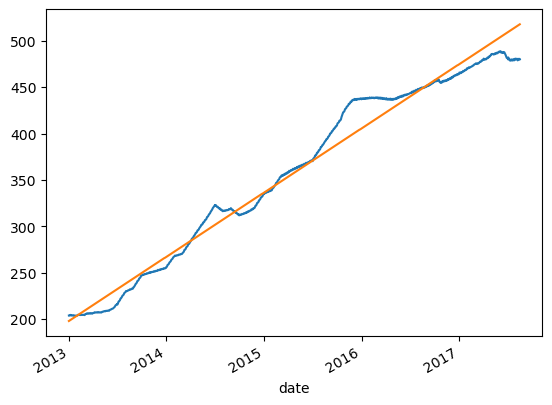

In [75]:
dp = DeterministicProcess(index=mean_yearly_sales.index, constant=True, order=1, drop=True)
X = dp.in_sample()
y = mean_yearly_sales
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

trend = pd.Series(model.predict(X), index=X.index)

ax = mean_yearly_sales.plot()
_ = trend.plot(ax=ax)

In [76]:
mean_yearly_sales.describe()

count    1684.000000
mean      358.020866
std        93.481243
min       203.559252
25%       270.316594
50%       362.210655
75%       442.434604
max       488.898347
Name: sales, dtype: float64

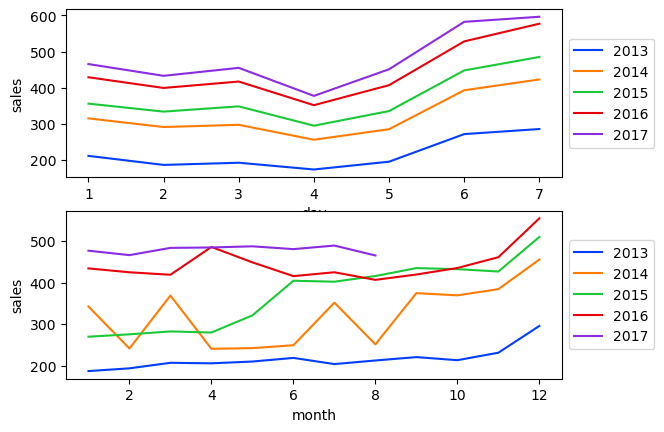

In [78]:
seasonal_graph_data = train.copy()
seasonal_graph_data["year"] = seasonal_graph_data.date.dt.year
seasonal_graph_data["day"] = seasonal_graph_data.date.dt.dayofweek + 1
seasonal_graph_data["month"] = seasonal_graph_data.date.dt.month
daily_graph_data = seasonal_graph_data.groupby(["year", "day"]).sales.mean().reset_index()
monthly_graph_data = seasonal_graph_data.groupby(["year", "month"]).sales.mean().reset_index()

fig, axes = plt.subplots(2, 1)
sns.lineplot(daily_graph_data, x="day", y='sales', hue='year', palette="bright", ax=axes[0])
sns.lineplot(monthly_graph_data, x="month", y='sales', hue='year', palette="bright", ax=axes[1])
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


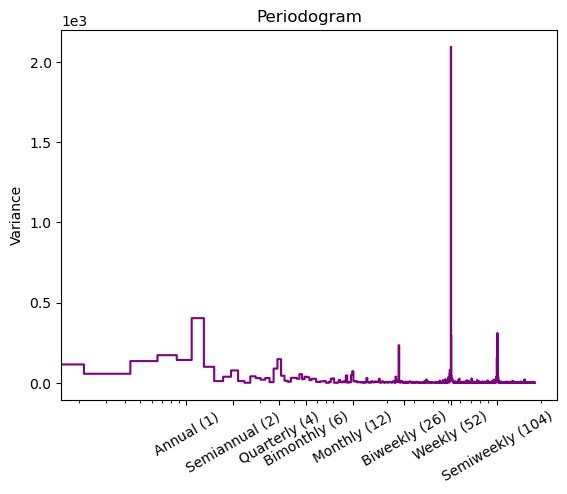

In [79]:
from forecasting_utils import plot_periodogram
plot_periodogram(mean_daily_sales-trend);

In [80]:
monthly_fourier = CalendarFourier(freq="M", order=4)
yearly_fourier = CalendarFourier(freq="A", order=4)

In [81]:
y=(mean_daily_sales-trend).copy()
y.index=train.groupby('date').mean().reset_index()['date'].dt.to_period('D')

dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=0,
                          seasonal=True,
                          additional_terms=[monthly_fourier, yearly_fourier],
                          drop=True
                          )
X=dp.in_sample()
print(X.columns)

Index(['s(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)'],
      dtype='object')


C:\Users\HM191112\AppData\Local\Temp\ipykernel_4312\383020930.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y.index=train.groupby('date').mean().reset_index()['date'].dt.to_period('D')


In [95]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
seasonal_fit = pd.Series(model.predict(X), index=trend.index)

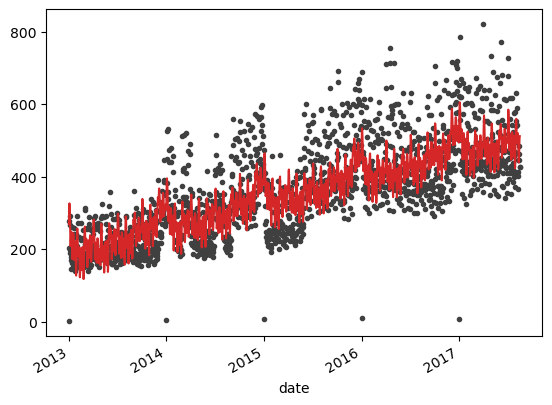

In [98]:
predictions = (trend + seasonal_fit)
ax = mean_daily_sales.plot(color='0.25',style='.')
ax = predictions.plot(ax=ax, color='C3')

In [ ]:
deseasoned_sales = mean_daily_sales -

In [100]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)